Tend 12.566370614359172
energy 0 0.0
Prior to start time loop. Hallo!
Elapsed time (min): 0.09284379084904988


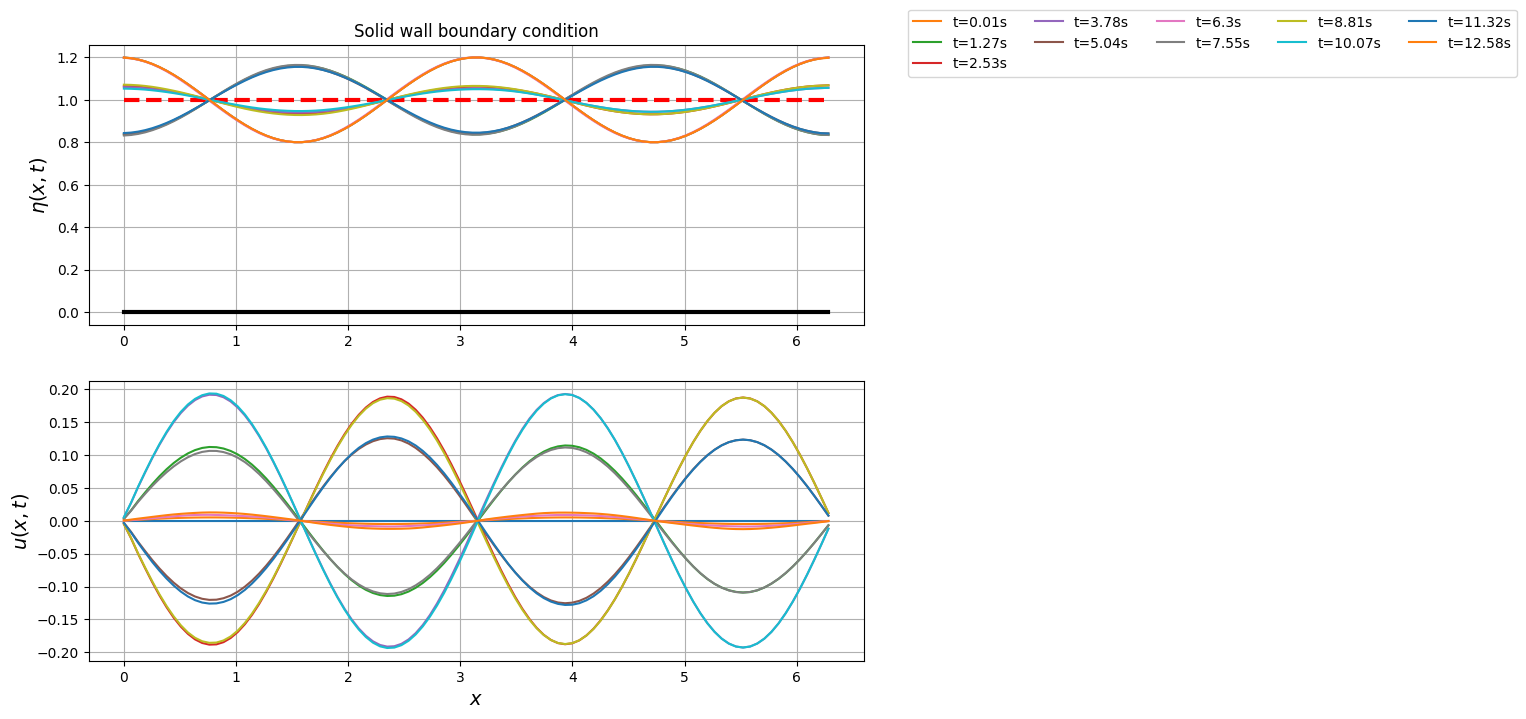

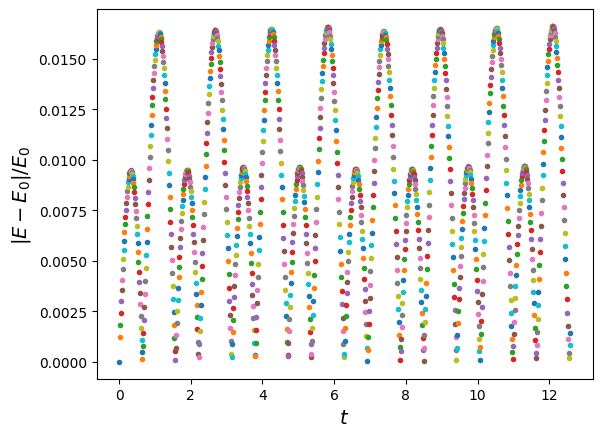

*************** PROGRAM ENDS ******************


In [35]:
#
#
#
#
import math
#
from firedrake import *
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import os.path
#import os ONNO 11-02-2023: no idea about opnumthreats warning?
os.environ["OMP_NUM_THREADS"] = "1"

def Hxxtopo(H0, W, L1, Hb, slope, xk12, Nb):
 if Nb<3: 
     return H0+0.0*xk12
 else:
     return H0*conditional(le(W+0.0*xk12,xk12),0.0+0.0*xk12,1.0+0.0*xk12)+Hb*conditional(le(xk12,L1+0.0*xk12),0.0+0.0*xk12,1.0+0.0*xk12)+(H0-slope*(xk12-W))*conditional(le(xk12,W+0.0*xk12),0.0+0.0*xk12,1.0+0.0*xk12)*conditional(le(L1+0.0*xk12,xk12),0.0+0.0*xk12,1.0+0.0*xk12);

def Hxxtopos(H0, W, L1, Hb, slope, xk12, Nb):
 if Nb<3: 
     return H0+0.0*xk12
 else:
     return H0*np.heaviside(W-xk12,0.5)+Hb*np.heaviside(xk12-L1,0.5)+(H0-slope*(xk12-W))*np.heaviside(xk12-W,0.5)*np.heaviside(L1-xk12,0.5);
# conditional(le(x[0],xb),0.0,sb*(x[0]-xb)))


# fdfff cvyy
# Parameters
#
Nbc = 1
if Nbc==1: # standing wave
    mint = 4
    grav = 1
    H0 = 1.0
    Lx = 2.0*np.pi
    Ld = Lx
    kw = np.pi*mint/Ld
    omeg = grav*kw
    ck = 0.2
    Nper = 4
    Tend = Nper*2.0*np.pi/omeg
    print('Tend',Tend)
    dt = Tend/1000
    nmea = 11
    tmeas = [0.0,Tend/10,2*Tend/10,3*Tend/10,4*Tend/10,5*Tend/10,6*Tend/10,7*Tend/10,8*Tend/10,9*Tend/10,Tend]
    tmease = 0.0
    dtmeas = Tend/10
    Nx = 100
    #nmea = 21
    #tmeas = [0.0,Tend/10,2*Tend/10,3*Tend/10,4*Tend/10,5*Tend/10,6*Tend/10,7*Tend/10,8*Tend/10,9*Tend/10,Tend]
elif Nbc==3:
    H0s = 40 # m
    H0 = 1
    Ld = 12
    gravr = 9.81
    grav = gravr/gravr
    Lx = Ld
    L1 = 10
    W = 2
    Hb = 0.1
    U0s = np.sqrt(gravr*H0s)
    slope = (H0-Hb)/(L1-W)
    bslope = 1.0/50.0
    Ls = slope*H0s/bslope
    Ts = Ls/U0s #
    Tps = 6  #
    Tp = Tps/Ts
    omeg = 2*pi/Tp
    print('Ls, Ts',Ls,Ts)
    kw = omeg/np.sqrt(grav*H0)
    As = 1 # m
    Ad = As/H0s
    Cc = grav*Ad*kw/omeg
    Nper = 45
    Tend = Nper*(2.0*np.pi/omeg)
    dt = Tend/1000
    c00 = np.sqrt(grav*H0)
    CFL = 1.0
    Nx = 4000
    dxx = Lx/Nx
    dt = CFL*dxx/np.amax(c00)
    nmea = 40
    tmease = 0.0
    dtmeas = Tend/nmea
else:
    Tend = 0.01*10.0
    Tend= 10
    dt = 0.005
    Lx = 2.0*np.pi
    grav = 1
    H0 = 1
    nmea = 11
    tmease = 0.0
    dtmeas = Tend/10
    # tmeas = [0.0,.01,.02,.03,.04,.05,.06,.07,.08,.09,.10]
    # tmeas = [0,1,2,3,4,5,6,7,8,9,10]
    Nx = 100
nnm = 0  # counter outputs

#
# Mesh
# mesh1d = UnitIntervalMesh(Nx)
mesh1d = IntervalMesh(Nx,Lx)
# 2D mesh: mesh = ExtrudedMesh(mesh1d, layers=Ny)
mesh = mesh1d
#  coords = mesh.coordinates
# 2D mesh and coordinates: coords.dat.data[:,0] = Lx*coords.dat.data[:,0] coords.dat.data = Lx*coords.dat.data
x, = SpatialCoordinate(mesh)

#
# Function spaces
#
nDG = 0
DG0 = FunctionSpace(mesh, "DG", nDG)
eta0 = Function(DG0, name="eta0")
uve0 = Function(DG0, name="uve0")
vve0 = Function(DG0, name="uve0")
eta1 = Function(DG0, name="eta1")
uve1 = Function(DG0, name="uve1")
eta_trial = TrialFunction(DG0)
uve_trial = TrialFunction(DG0)
deta_test = TestFunction(DG0)
duve_test = TestFunction(DG0)
dvve_test = TestFunction(DG0)

#
# We define n to be the built-in FacetNormal object;
# a unit normal vector that can be used in integrals over exterior and interior facets.
# We next define un to be an object which is equal to 
# if this is positive, and zero if this is negative. This will be useful in the upwind terms.
# how to distinguish interior from exterior facets?
#
# wrong etan = 0.5*(dot(u, n) + abs(dot(u, n)))
# wrong un = 0.5*(dot(u, n) + abs(dot(u, n)))

# initial condtion and plot it
tijd = 0.0
if Nbc==1: # standing wave
    mint = 4
    H0 = 1.0
    Ld = Lx
    kw = np.pi*mint/Ld
    omeg = grav*kw
    ck = 0.2
    Nper = 10.0
    eta0 = Function(DG0).interpolate( ck*cos(mint*np.pi*x/Ld)*cos(omeg*tijd) ) # u1 is eta
    uve0 = Function(DG0).interpolate( (omeg*ck/H0)*(Ld/(mint*np.pi))*sin(mint*pi*x/Ld)*sin(omeg*tijd) ) # u2 is velocity
    vve0 = 0.0*x
    Hx = Hxxtopo(H0, 0.0, 0.0, 0.0, 0.0, x, Nbc)
    # q = Function(V).interpolate(1.0 + bell + cone + slot_cyl)
    # q_init = Function(V).assign(q)
elif Nbc==3: # rest flow
    Hx = Hxxtopo(H0, W, L1, Hb, slope, x, Nbc)
    eta0 = Function(DG0).interpolate(0.0+0.0*x)
    uve0 = Function(DG0).interpolate(0.0+0.0*x)
    
    # u2 = 0.0*xmk
    # Hx = Hxxtopo(H0, W, L1, Hb, slope, Xce, Nbc)
t = tijd
t_ = Constant(t)
smallfac = 10.0**(-10.0)

nx = Nx
xsmall = 0.0*10**(-6)
xvals = np.linspace(0+xsmall, Lx-xsmall, nx)
fig, (ax1, ax2,) = plt.subplots(2, figsize=(10, 8))
tsize = 14
#ax1.set_title(r'$t=0,2,4,5,5.5,6,6.5,8.5,9.5$',fontsize=tsize)
ax1.set_ylabel(r'$\eta(x,t)$ ',fontsize=tsize)
ax1.grid()
ax2.set_xlabel(r'$x$ ',fontsize=tsize)
ax2.set_ylabel(r'$u(x,t)$ ',fontsize=tsize)
nVP = 0
if Nbc==1:
    Hxvals = Hxxtopos(H0, 0.0, 0.0, 0.0, 0.0, xvals, Nbc)
elif Nbc==3:
    Hxvals = Hxxtopos(H0, W, L1, Hb, slope, xvals, Nbc)
else:
    Hxvals = Hxxtopos(H0, 0.0, 0.0, 0.0, 0.0, xvals, Nbc)

if nVP==2:
    ax3.set_xlabel(r'$x$ ',fontsize=tsize)
    ax3.set_ylabel(r'$\nu_b(x,t)$ ',fontsize=tsize)
ax2.grid()
eta12 = np.array([eta0.at(x) for x in xvals]) # eta12 = np.array([eta0.at(x) for x in xvals])
phi12 = np.array([uve0.at(x) for x in xvals])
ax1.plot(xvals,(H0+eta12)) #, color[int(i-1)],label = f' $\eta_n: t = {t:.3f}$')

Nkel = 40  # number of element
Xce = np.zeros(Nkel+1)

dxx = Lx/Nkel
Hxt = H0+0.0*Xce
for jj in range(0,Nkel+1):   
    Xce[jj] = jj*dxx
    if Nbc==1: # standing wave
        Hxt[jj] = Hxxtopos(H0, 0.0, 0.0, 0.0, 0.0, Xce[jj], Nbc)
    elif Nbc==3: # rest flow
        Hxt[jj] = Hxxtopos(H0, W, L1, Hb, slope, Xce[jj], Nbc)

if Nbc==1: # standing wave
    Hxt = Hxxtopos(H0, 0.0, 0.0, 0.0, 0.0, Xce, Nbc)
elif Nbc==3: # rest flow
 Hxt = Hxxtopos(H0, W, L1, Hb, slope, Xce, Nbc)


ax1.plot(Xce,(H0-Hxt),'k',lw=3) #, color[int(i-1)],label = f' $\eta_n: t = {t:.3f}$')
ax1.plot(Xce, np.array([H0 for i in range(len(Xce))]), linestyle='--', color='r', lw=3)  # Red dashed line
#ax1.plot( Xce,( (H0/Hxt)**thetaa ),'--r',lw=2 ) # asymptotics 
ax2.plot(xvals,phi12) #, color[int(i-1)], label = f' $\phi_n: t = {t:.3f}$')

#if t==tmeas[nnm]:
#    nnm = nnm+1

t = 0
tmE = 0.0
E0 = assemble( (0.5*Hx*uve0**2 + 0.5*grav*eta0**2)*dx )
E = E0
plt.figure(2)
if Nbc==1:
    print('energy',t, abs((E-E0)/E0))
    plt.plot(t,abs(E-E0)/E0,'.')
    plt.ylabel(r'$|E-E_0|/E_0$ ',fontsize=tsize)
    dte = dt
elif Nbc==3:
    print('energy',t, E)
    plt.plot(t,E,'.')
    plt.ylabel(r'$E$ ',fontsize=tsize)
    dte = 20*dt
tmE = tmE+dte
plt.xlabel(r'$t$ ',fontsize=tsize)

# 
# 
# weak forms
thetaa =0.25
# n = FacetNormal(mesh); odd normals in 1d one at first face is likely wrong
n = as_vector([1.0]) 
a_masseta = deta_test * eta_trial * dx
u20 = Constant(0.0)
u10 = Constant(0.0)

Fetaflux = thetaa*Hx*(n[0] * (uve0('+'))) + (1-thetaa)*Hx*(n[0] * (uve0('-'))) # inner product outcome a scalar fails topograh Hx continuous
if Nbc==1:
    Fetafluxbcl = thetaa*Hx*(n[0] * (uve0)) - (1-thetaa)*Hx*(n[0] * (uve0)) # inner product outcome a scalar fails
    Fetafluxbcr = thetaa*Hx*(n[0] * (uve0)) - (1-thetaa)*Hx*(n[0] * (uve0)) # inner product outcome a scalar fails

etarhs = deta_test * eta0 * dx - dt*Fetaflux*(deta_test('+')-deta_test('-'))*dS # derivative of test function zero for DG0
etarhs = etarhs + dt*Fetafluxbcl*deta_test*ds(1) - dt*Fetafluxbcr*deta_test*ds(2) # note ugly plus sign in ds(1) intuition not in the maths; due to odd normals in 1d
eta_problem = LinearVariationalProblem(a_masseta, etarhs, eta1)

a_massuve = duve_test * uve_trial * dx # inner product 
Fuveflux = (1-thetaa)*grav*eta1('+') + thetaa*grav*eta1('-') # always a scalar anti-symmetric flux
if Nbc==1:
    Fuvefluxbcl = (1-thetaa)*grav*eta1 + thetaa*grav*eta1 # extrapolating condition left solid wall for standing waves
    Fuvefluxbcr = (1-thetaa)*grav*eta1 + thetaa*grav*eta1 # extrapolating condition right solid wall for standing waves

uverhs = duve_test * uve0 * dx  - dt*Fuveflux*(n[0]*(duve_test('+')-duve_test('-')))*dS
uverhs = uverhs + dt*Fuvefluxbcl*(n[0]*duve_test)*ds(1) - dt*Fuvefluxbcr*(n[0]*duve_test)*ds(2)  # note ugly plus sign in ds(1) not in the maths; due to odd normals in 1d
uve_problem = LinearVariationalProblem(a_massuve, uverhs, uve1)

# params = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
# Since we have arranged that the matrix A is diagonal, we can invert it with a single application of Jacobi iteration. We select this here using appropriate solver parameters, which tell PETSc to construct a solver which just applies a single step of Jacobi preconditioning. See: https://www.firedrakeproject.org/demos/higher_order_mass_lumping.py.html
params= {"ksp_type": "preonly", "pc_type": "jacobi"}
solv1 = LinearVariationalSolver(eta_problem, solver_parameters=params)
solv2 = LinearVariationalSolver(uve_problem, solver_parameters=params)
#  solv1 = LinearVariationalSolver(eta_problem)
#  solv2 = LinearVariationalSolver(uve_problem)

dt0 = dt
dt = 0.0
t_.assign(t)
if Nbc==3:
    u20.assign((grav*Ad*kw/omeg)*sin(-omeg*t))
    u10.assign(Ad*sin(-omeg*t)) # eta
    
solv1.solve()
solv2.solve()
dt = dt0

print('Prior to start time loop. Hallo!')

tic = time.time()
while t <= Tend:
    t += dt
    
    t_.assign(t)
    if Nbc==3:
        u20.assign((grav*Ad*kw/omeg)*sin(-omeg*t))
        u10.assign(Ad*sin(-omeg*t)) # eta
      
    solv1.solve()
    solv2.solve()
    eta0.assign(eta1)
    uve0.assign(uve1)

    
    #solv2.solve()  # Solve for updated velocity uve1
    #uve0.assign(uve1)  # Assign the updated velocity to uve0

    #solv1.solve()  # Solve for updated eta1
    #eta0.assign(eta1)  # Assign the updated position-like field to eta0
    
    if t>tmease+smallfac:
        # print('t, tmeas:',t, tmease)
        tmease = tmease + dtmeas
        nnm = nnm+1
        eta12 = np.array([eta0.at(x) for x in xvals]) # eta12 = np.array([eta0.at(x) for x in xvals])
        phi12 = np.array([uve0.at(x) for x in xvals])
        
        ax1.plot(xvals, (H0 + eta12), label=f't={round(t,2)}s')  # Corrected label formatting
        ax2.plot(xvals, phi12) #, color[int(i-1)], label = f' $\phi_n: t = {t:.3f}$')

    if t>tmE+smallfac:
        plt.figure(2)
        E = assemble( (0.5*Hx*uve0**2 + 0.5*eta0**2)*dx )
        if Nbc==1:
            # print('energy',t, abs((E-E0)/E0))
            plt.plot(t,abs(E-E0)/E0,'.')
        elif Nbc==3:
            # print('energy',t, E)
            plt.plot(t,E,'.')
        tmE = tmE+dte
          
toc = time.time() - tic
print('Elapsed time (min):', toc/60)
ax1.legend(loc='upper center', bbox_to_anchor=(1.45, 1.15), ncol=5)
ax1.set_title('Solid wall boundary condition')
plt.show() 


print('*************** PROGRAM ENDS ******************')

>Question 7

Tend 12.566370614359172
energy 0 0.0
Prior to start time loop. Hallo!
Elapsed time (min): 0.09088001648585002


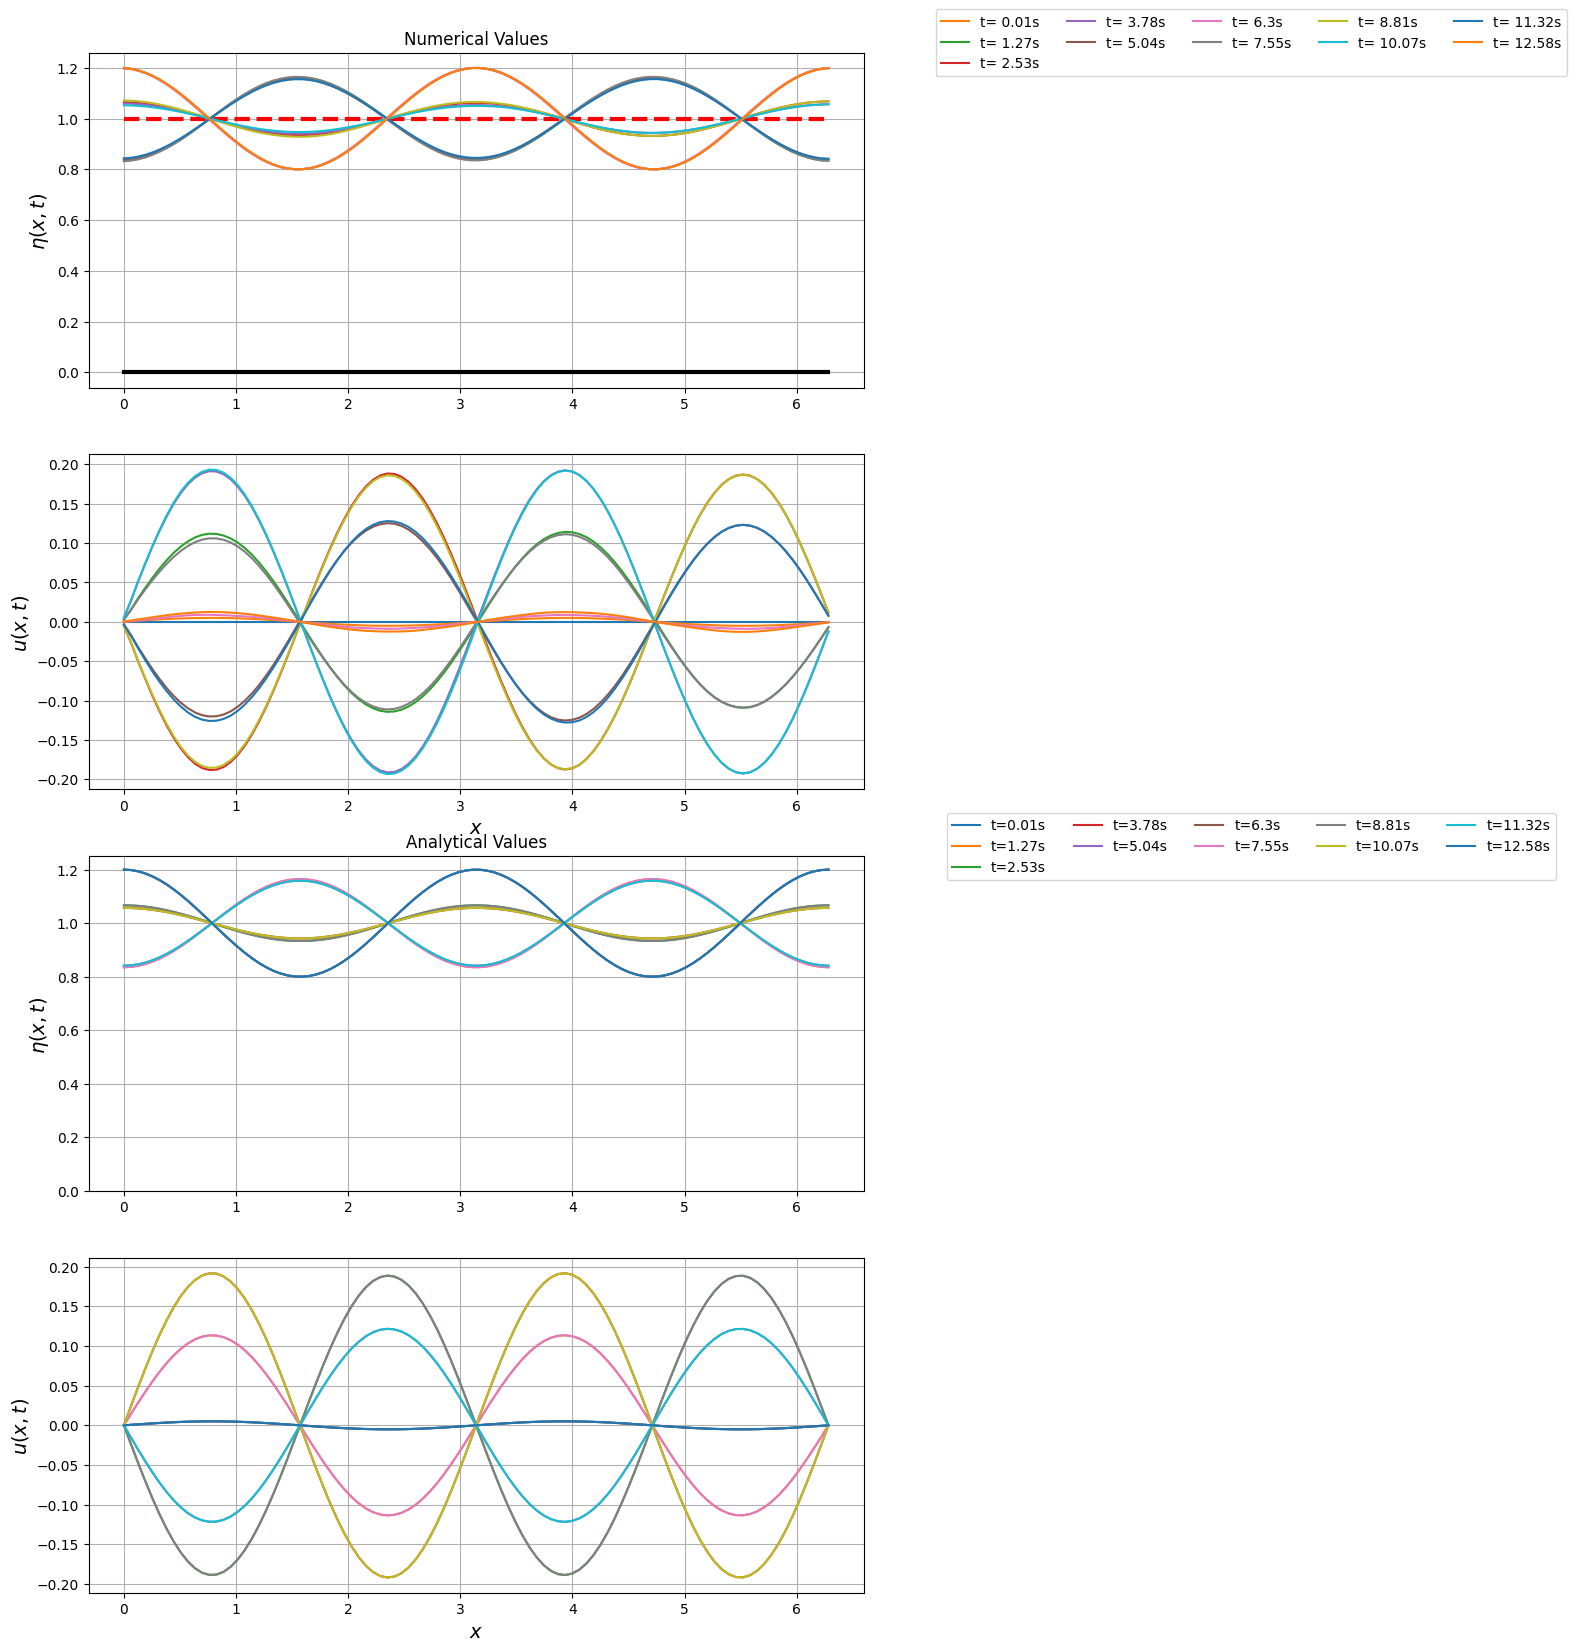

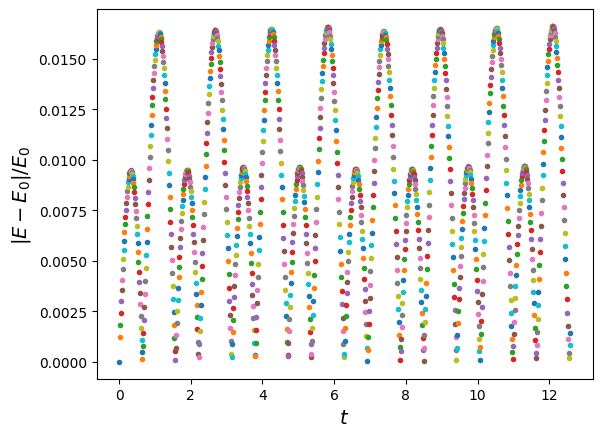

*************** PROGRAM ENDS ******************


In [38]:
#
#
#
#
import math
#
from firedrake import *
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import os.path
#import os ONNO 11-02-2023: no idea about opnumthreats warning?
os.environ["OMP_NUM_THREADS"] = "1"

def Hxxtopo(H0, W, L1, Hb, slope, xk12, Nb):
 if Nb<3: 
     return H0+0.0*xk12
 else:
     return H0*conditional(le(W+0.0*xk12,xk12),0.0+0.0*xk12,1.0+0.0*xk12)+Hb*conditional(le(xk12,L1+0.0*xk12),0.0+0.0*xk12,1.0+0.0*xk12)+(H0-slope*(xk12-W))*conditional(le(xk12,W+0.0*xk12),0.0+0.0*xk12,1.0+0.0*xk12)*conditional(le(L1+0.0*xk12,xk12),0.0+0.0*xk12,1.0+0.0*xk12);

def Hxxtopos(H0, W, L1, Hb, slope, xk12, Nb):
 if Nb<3: 
     return H0+0.0*xk12
 else:
     return H0*np.heaviside(W-xk12,0.5)+Hb*np.heaviside(xk12-L1,0.5)+(H0-slope*(xk12-W))*np.heaviside(xk12-W,0.5)*np.heaviside(L1-xk12,0.5);
# conditional(le(x[0],xb),0.0,sb*(x[0]-xb)))


# fdfff cvyy
# Parameters
#
Nbc = 1
if Nbc==1: # standing wave
    mint = 4
    grav = 1
    H0 = 1.0
    Lx = 2.0*np.pi
    Ld = Lx
    kw = np.pi*mint/Ld
    omeg = grav*kw
    ck = 0.2
    Nper = 4
    Tend = Nper*2.0*np.pi/omeg
    print('Tend',Tend)
    dt = Tend/1000
    nmea = 11
    tmeas = [0.0,Tend/10,2*Tend/10,3*Tend/10,4*Tend/10,5*Tend/10,6*Tend/10,7*Tend/10,8*Tend/10,9*Tend/10,Tend]
    tmease = 0.0
    dtmeas = Tend/10
    Nx = 100
    #nmea = 21
    #tmeas = [0.0,Tend/10,2*Tend/10,3*Tend/10,4*Tend/10,5*Tend/10,6*Tend/10,7*Tend/10,8*Tend/10,9*Tend/10,Tend]
elif Nbc==3:
    H0s = 40 # m
    H0 = 1
    Ld = 12
    gravr = 9.81
    grav = gravr/gravr
    Lx = Ld
    L1 = 10
    W = 2
    Hb = 0.1
    U0s = np.sqrt(gravr*H0s)
    slope = (H0-Hb)/(L1-W)
    bslope = 1.0/50.0
    Ls = slope*H0s/bslope
    Ts = Ls/U0s #
    Tps = 6  #
    Tp = Tps/Ts
    omeg = 2*pi/Tp
    print('Ls, Ts',Ls,Ts)
    kw = omeg/np.sqrt(grav*H0)
    As = 1 # m
    Ad = As/H0s
    Cc = grav*Ad*kw/omeg
    Nper = 45
    Tend = Nper*(2.0*np.pi/omeg)
    dt = Tend/1000
    c00 = np.sqrt(grav*H0)
    CFL = 1.0
    Nx = 4000
    dxx = Lx/Nx
    dt = CFL*dxx/np.amax(c00)
    nmea = 40
    tmease = 0.0
    dtmeas = Tend/nmea
else:
    Tend = 0.01*10.0
    Tend= 10
    dt = 0.005
    Lx = 2.0*np.pi
    grav = 1
    H0 = 1
    nmea = 11
    tmease = 0.0
    dtmeas = Tend/10
    # tmeas = [0.0,.01,.02,.03,.04,.05,.06,.07,.08,.09,.10]
    # tmeas = [0,1,2,3,4,5,6,7,8,9,10]
    Nx = 100
nnm = 0  # counter outputs

#
# Mesh
# mesh1d = UnitIntervalMesh(Nx)
mesh1d = IntervalMesh(Nx,Lx)
# 2D mesh: mesh = ExtrudedMesh(mesh1d, layers=Ny)
mesh = mesh1d
#  coords = mesh.coordinates
# 2D mesh and coordinates: coords.dat.data[:,0] = Lx*coords.dat.data[:,0] coords.dat.data = Lx*coords.dat.data
x, = SpatialCoordinate(mesh)

#
# Function spaces
#
nDG = 0
DG0 = FunctionSpace(mesh, "DG", nDG)
eta0 = Function(DG0, name="eta0")
uve0 = Function(DG0, name="uve0")
vve0 = Function(DG0, name="uve0")
eta1 = Function(DG0, name="eta1")
uve1 = Function(DG0, name="uve1")
eta_trial = TrialFunction(DG0)
uve_trial = TrialFunction(DG0)
deta_test = TestFunction(DG0)
duve_test = TestFunction(DG0)
dvve_test = TestFunction(DG0)

#
# We define n to be the built-in FacetNormal object;
# a unit normal vector that can be used in integrals over exterior and interior facets.
# We next define un to be an object which is equal to 
# if this is positive, and zero if this is negative. This will be useful in the upwind terms.
# how to distinguish interior from exterior facets?
#
# wrong etan = 0.5*(dot(u, n) + abs(dot(u, n)))
# wrong un = 0.5*(dot(u, n) + abs(dot(u, n)))

# initial condtion and plot it
tijd = 0.0
if Nbc==1: # standing wave
    mint = 4
    H0 = 1.0
    Ld = Lx
    kw = np.pi*mint/Ld
    omeg = grav*kw
    ck = 0.2
    Nper = 10.0
    eta0 = Function(DG0).interpolate( ck*cos(mint*np.pi*x/Ld)*cos(omeg*tijd) ) # u1 is eta
    uve0 = Function(DG0).interpolate( (omeg*ck/H0)*(Ld/(mint*np.pi))*sin(mint*pi*x/Ld)*sin(omeg*tijd) ) # u2 is velocity
    vve0 = 0.0*x
    Hx = Hxxtopo(H0, 0.0, 0.0, 0.0, 0.0, x, Nbc)
    # q = Function(V).interpolate(1.0 + bell + cone + slot_cyl)
    # q_init = Function(V).assign(q)
elif Nbc==3: # rest flow
    Hx = Hxxtopo(H0, W, L1, Hb, slope, x, Nbc)
    eta0 = Function(DG0).interpolate(0.0+0.0*x)
    uve0 = Function(DG0).interpolate(0.0+0.0*x)
    
    # u2 = 0.0*xmk
    # Hx = Hxxtopo(H0, W, L1, Hb, slope, Xce, Nbc)
t = tijd
t_ = Constant(t)
smallfac = 10.0**(-10.0)

nx = Nx
xsmall = 0.0*10**(-6)
xvals = np.linspace(0+xsmall, Lx-xsmall, nx)
fig, (ax1, ax2,ax3, ax4) = plt.subplots(4, figsize=(10, 20))
tsize = 14
#ax1.set_title(r'$t=0,2,4,5,5.5,6,6.5,8.5,9.5$',fontsize=tsize)

ax1.set_title("Numerical Values")
ax1.set_ylabel(r'$\eta(x,t)$ ',fontsize=tsize)
ax1.grid()
ax2.set_xlabel(r'$x$ ',fontsize=tsize)
ax2.set_ylabel(r'$u(x,t)$ ',fontsize=tsize)
ax3.set_ylabel(r'$\eta(x,t)$ ',fontsize=tsize)
ax3.set_title("Analytical Values")
ax3.set_ylim(0, 1.25)
ax4.set_ylabel(r'$u(x,t)$ ',fontsize=tsize)
ax4.set_xlabel(r'$x$ ',fontsize=tsize)

nVP = 0
if Nbc==1:
    Hxvals = Hxxtopos(H0, 0.0, 0.0, 0.0, 0.0, xvals, Nbc)
elif Nbc==3:
    Hxvals = Hxxtopos(H0, W, L1, Hb, slope, xvals, Nbc)
else:
    Hxvals = Hxxtopos(H0, 0.0, 0.0, 0.0, 0.0, xvals, Nbc)

if nVP==2:
    ax3.set_xlabel(r'$x$ ',fontsize=tsize)
    ax3.set_ylabel(r'$\nu_b(x,t)$ ',fontsize=tsize)
ax2.grid()
eta12 = np.array([eta0.at(x) for x in xvals]) # eta12 = np.array([eta0.at(x) for x in xvals])
phi12 = np.array([uve0.at(x) for x in xvals])
ax1.plot(xvals,(H0+eta12)) #, color[int(i-1)],label = f' $\eta_n: t = {t:.3f}$')

Nkel = 40  # number of element
Xce = np.zeros(Nkel+1)

dxx = Lx/Nkel
Hxt = H0+0.0*Xce
for jj in range(0,Nkel+1):   
    Xce[jj] = jj*dxx
    if Nbc==1: # standing wave
        Hxt[jj] = Hxxtopos(H0, 0.0, 0.0, 0.0, 0.0, Xce[jj], Nbc)
    elif Nbc==3: # rest flow
        Hxt[jj] = Hxxtopos(H0, W, L1, Hb, slope, Xce[jj], Nbc)

if Nbc==1: # standing wave
    Hxt = Hxxtopos(H0, 0.0, 0.0, 0.0, 0.0, Xce, Nbc)
elif Nbc==3: # rest flow
 Hxt = Hxxtopos(H0, W, L1, Hb, slope, Xce, Nbc)


ax1.plot(Xce,(H0-Hxt),'k',lw=3) #, color[int(i-1)],label = f' $\eta_n: t = {t:.3f}$')
ax1.plot(Xce, np.array([H0 for i in range(len(Xce))]), linestyle='--', color='r', lw=3)  # Red dashed line
#ax1.plot( Xce,( (H0/Hxt)**thetaa ),'--r',lw=2 ) # asymptotics 
ax2.plot(xvals,phi12) #, color[int(i-1)], label = f' $\phi_n: t = {t:.3f}$')

#if t==tmeas[nnm]:
#    nnm = nnm+1

t = 0
tmE = 0.0
E0 = assemble( (0.5*Hx*uve0**2 + 0.5*grav*eta0**2)*dx )
E = E0
plt.figure(2)
if Nbc==1:
    print('energy',t, abs((E-E0)/E0))
    plt.plot(t,abs(E-E0)/E0,'.')
    plt.ylabel(r'$|E-E_0|/E_0$ ',fontsize=tsize)
    dte = dt
elif Nbc==3:
    print('energy',t, E)
    plt.plot(t,E,'.')
    plt.ylabel(r'$E$ ',fontsize=tsize)
    dte = 20*dt
tmE = tmE+dte
plt.xlabel(r'$t$ ',fontsize=tsize)

# 
# 
# weak forms
thetaa =0.25
# n = FacetNormal(mesh); odd normals in 1d one at first face is likely wrong
n = as_vector([1.0]) 
a_masseta = deta_test * eta_trial * dx
u20 = Constant(0.0)
u10 = Constant(0.0)

Fetaflux = thetaa*Hx*(n[0] * (uve0('+'))) + (1-thetaa)*Hx*(n[0] * (uve0('-'))) # inner product outcome a scalar fails topograh Hx continuous
if Nbc==1:
    Fetafluxbcl = thetaa*Hx*(n[0] * (uve0)) - (1-thetaa)*Hx*(n[0] * (uve0)) # inner product outcome a scalar fails
    Fetafluxbcr = thetaa*Hx*(n[0] * (uve0)) - (1-thetaa)*Hx*(n[0] * (uve0)) # inner product outcome a scalar fails

etarhs = deta_test * eta0 * dx - dt*Fetaflux*(deta_test('+')-deta_test('-'))*dS # derivative of test function zero for DG0
etarhs = etarhs + dt*Fetafluxbcl*deta_test*ds(1) - dt*Fetafluxbcr*deta_test*ds(2) # note ugly plus sign in ds(1) intuition not in the maths; due to odd normals in 1d
eta_problem = LinearVariationalProblem(a_masseta, etarhs, eta1)

a_massuve = duve_test * uve_trial * dx # inner product 
Fuveflux = (1-thetaa)*grav*eta1('+') + thetaa*grav*eta1('-') # always a scalar anti-symmetric flux
if Nbc==1:
    Fuvefluxbcl = (1-thetaa)*grav*eta1 + thetaa*grav*eta1 # extrapolating condition left solid wall for standing waves
    Fuvefluxbcr = (1-thetaa)*grav*eta1 + thetaa*grav*eta1 # extrapolating condition right solid wall for standing waves

uverhs = duve_test * uve0 * dx  - dt*Fuveflux*(n[0]*(duve_test('+')-duve_test('-')))*dS
uverhs = uverhs + dt*Fuvefluxbcl*(n[0]*duve_test)*ds(1) - dt*Fuvefluxbcr*(n[0]*duve_test)*ds(2)  # note ugly plus sign in ds(1) not in the maths; due to odd normals in 1d
uve_problem = LinearVariationalProblem(a_massuve, uverhs, uve1)

# params = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
# Since we have arranged that the matrix A is diagonal, we can invert it with a single application of Jacobi iteration. We select this here using appropriate solver parameters, which tell PETSc to construct a solver which just applies a single step of Jacobi preconditioning. See: https://www.firedrakeproject.org/demos/higher_order_mass_lumping.py.html
params= {"ksp_type": "preonly", "pc_type": "jacobi"}
solv1 = LinearVariationalSolver(eta_problem, solver_parameters=params)
solv2 = LinearVariationalSolver(uve_problem, solver_parameters=params)
#  solv1 = LinearVariationalSolver(eta_problem)
#  solv2 = LinearVariationalSolver(uve_problem)

dt0 = dt
dt = 0.0
t_.assign(t)
if Nbc==3:
    u20.assign((grav*Ad*kw/omeg)*sin(-omeg*t))
    u10.assign(Ad*sin(-omeg*t)) # eta
    
solv1.solve()
solv2.solve()
dt = dt0

print('Prior to start time loop. Hallo!')

tic = time.time()
while t <= Tend:
    t += dt
    
    t_.assign(t)
    if Nbc==3:
        u20.assign((grav*Ad*kw/omeg)*sin(-omeg*t))
        u10.assign(Ad*sin(-omeg*t)) # eta
      
    solv1.solve()
    solv2.solve()
    eta0.assign(eta1)
    uve0.assign(uve1)

    
    #solv2.solve()  # Solve for updated velocity uve1
    #uve0.assign(uve1)  # Assign the updated velocity to uve0

    #solv1.solve()  # Solve for updated eta1
    #eta0.assign(eta1)  # Assign the updated position-like field to eta0
    def eta_analytical(x, t, H0, mint, Ld):
        return ck*np.cos(mint*np.pi*x/Ld)*np.cos(omeg*t)

    def u_analytical(x,t,H0,mint,Ld):
        return omeg*(ck/H0)*(Ld/(mint*np.pi))*np.sin(mint*pi*x/Ld)*np.sin(omeg*t) 
    
    if t>tmease+smallfac:
        # print('t, tmeas:',t, tmease)
        tmease = tmease + dtmeas
        nnm = nnm+1
        eta12 = np.array([eta0.at(x) for x in xvals]) # eta12 = np.array([eta0.at(x) for x in xvals])
        phi12 = np.array([uve0.at(x) for x in xvals])
        #eta_analytical_values = np.array([float(eta_analytical(x, t, H0, mint, Ld)) for x in xvals])
        eta_analytical_values = np.array([float(eta_analytical(x, t, H0, mint, Ld)) for x in xvals])
        u_analytical_values = np.array([float(u_analytical(x, t, H0, mint, Ld)) for x in xvals])
        
        ax1.plot(xvals, (H0 + eta12), label=f't= {round(t,2)}s')  # Corrected label formatting
        ax2.plot(xvals, phi12) #, color[int(i-1)], label = f' $\phi_n: t = {t:.3f}$')
        ax3.plot(xvals, H0+eta_analytical_values,label=f't={round(t,2)}s')
        ax4.plot(xvals, u_analytical_values)
        ax3.grid(True)
        ax4.grid(True)

    if t>tmE+smallfac:
        plt.figure(2)
        E = assemble( (0.5*Hx*uve0**2 + 0.5*eta0**2)*dx )
        if Nbc==1:
            # print('energy',t, abs((E-E0)/E0))
            plt.plot(t,abs(E-E0)/E0,'.')
        elif Nbc==3:
            # print('energy',t, E)
            plt.plot(t,E,'.')
        tmE = tmE+dte
          
toc = time.time() - tic
print('Elapsed time (min):', toc/60)

ax1.legend(loc='upper center', bbox_to_anchor=(1.5, 1.15), ncol=5)  # Adjust ncol as needed
#ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5)
ax3.legend(loc='upper center', bbox_to_anchor=(1.5, 1.15), ncol=5)
plt.show() 


print('*************** PROGRAM ENDS ******************')